# Output Tracking using Physics Informed Neural Networks (PINNs)

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

import torch
import torch.nn as nn               # neural networks
import torch.optim as optim         # optimizer 
import torch.autograd as autograd   # automatic gradient
from torch.nn.utils import parameters_to_vector
import time
#PyTorch RNG seed
torch.manual_seed(22017)
# NumPy RNG seed
np.random.seed(22017)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 1.13.1
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:36:24_Pacific_Standard_Time_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
**********
CUDNN version: 8302
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


# 1. Introduction

**Physics Informed Neural Networks** is a type of *artificial neural network* with the ability to solve partial differential equations. In the neural network learning process, PINNs is able to embed the knowledge of physical laws that governs a data set that can be described by a PDEs. 

Observe a nonlinear control system SISO (*single-input-single-output*) as follows:
\begin{align*}
\dot{\textbf{x}} &= f(\textbf{x}) + g(\textbf{x})u\\
y &= h(\textbf{x})
\end{align*}
with $\textbf{x}\in \mathbb{R}^n$ as state vector (*state vector*), $u\in \mathbb{R}$ as control input, $f:\mathbb{R}^n \to \mathbb{R}^n$ smooth function with $f(\textbf{0})=\textbf{0}$ and $h:\mathbb{R}^n \to \mathbb{R}^n$ also smooth functions. Additionaly, is is also assumed that $h(\textbf{0})= \textbf{0}$. 

Tracking problem in control theory is to determine the appropriate control input $u$ in such a way so that the output $y(t)$ will converge to the desired output $y_d(t)$ overtime. In this project, we will be utilizing PINNs to solve the tracking problem on nonlinear control system. 









# 2. Problem Formulation

First, we have to formulate the appropriate loss functions to train the neural networks. Consider a network accepting an input of $t$ and producing $\textbf{x},u$ as the outputs (see figure below)



 ![title](Scheme_PINN_tracking.jpg)

We will adjust the loss functions so that the neural network does two things:
1. It solves the system $\dot{\textbf{x}}=f(\textbf{x}) + g(\textbf{x})u$,
2. It adjusts the control input $u$ accordingly so $y(t)\to y_d(t)$ as $t$ grows

For demonstration purpose, observe the nonlinear control system below:
\begin{align*}
\dot{x_1} &= x_2 + 2x_1^2\\
\dot{x_2} &= x_3 + u\\
\dot{x_3} &= x_1 + x_3\\
y &= h(x, t)
\end{align*}
with the desired output $y_d = \sin(t)$. 

We have two different cases here based on the system output:
1. If $h(x,t)=x_3$, the system becomes minimum phase.
2. If $h(x,t)=x_1$, the system becomes non-minimum phase.

Later, we will demonstrate the PINN for two cases above. 



## 2.1 Loss Functions Formulation

For the first case, we will formulate the loss function as follows:
\begin{align*}
\mathcal{L}_{f_1} &=\dfrac{\partial x_1}{\partial t} - x_2 - 2x_1^2\\
\mathcal{L}_{f_2} &=\dfrac{\partial x_2}{\partial t} - x_3 - u \\
\mathcal{L}_{f_3} &=\dfrac{\partial x_3}{\partial t} - x_1 - x_3\\
\mathcal{L}_{t} &=x_3 - \sin(t)
\end{align*}

while for the latter case we have:
\begin{align*}
\mathcal{L}_{f_1} &=\dfrac{\partial x_1}{\partial t} - x_2 - 2x_1^2\\
\mathcal{L}_{f_2} &=\dfrac{\partial x_2}{\partial t} - x_3 - u \\
\mathcal{L}_{f_3} &=\dfrac{\partial x_3}{\partial t} - x_1 - x_3\\
\mathcal{L}_{t} &=x_1 - \sin(t)
\end{align*}

Note that the only difference is on the tracking loss $\mathcal{L}_t$.

In [5]:
class case1_PINN(nn.Module):
    def __init__(self, params, layers, inits, batch_num = 5):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        # Xavier Normal weight inits, set the bias to zero.
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data)
            nn.init.zeros_(self.linears[i].bias.data)
        self.activation = nn.Tanh()
        self.MSE = nn.MSELoss()
        # Default parameters
        self.layers = layers
        T, Nt = params
        self.T = T
        x1_0, x2_0, x3_0 = inits
        self.x1_0 = x1_0
        self.x2_0 = x2_0
        self.x3_0 = x3_0
        # Training data 
        self.t_rands = torch.rand(Nt, 1)*T # random [0, T]
        # Batch indexes
        self.batch_idxs = torch.randperm(Nt)
        self.batch_sz = int(Nt/batch_num)
        
    # Forward pass
    # v = [x1, x2, x3, u]
    def forward(self, t):
        if torch.is_tensor(t) != True:
            t = torch.from_numpy(t)
        a = t.float()
        for i in range(len(self.layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    # Loss function
    def f_func(self, t):
        v_hat = self.forward(t).to(device)
        x1_hat = v_hat[:, [0]]
        x2_hat = v_hat[:, [1]]
        x3_hat = v_hat[:, [2]]
        u_hat = v_hat[:, [3]]
        
    def losses(self, batch_no=0, mini_batch=False):
        if mini_batch:
            sz = self.batch_sz
            batch_idx = self.batch_idxs[sz*batch_no:sz*(batch_no+1)]
            t_in = self.t_rands.to(device)[batch_idx]
        else:
            t_in = self.t_rands.to(device)
        t_in.requires_grad = True
        v_hat = self.forward(t_in).to(device)
        x1_hat = v_hat[:, [0]]
        x2_hat = v_hat[:, [1]]
        x3_hat = v_hat[:, [2]]
        u_hat = v_hat[:, [3]]
        x1_dot = torch.autograd.grad(x1_hat, t_in,
                                    torch.ones_like(x1_hat).to(device), 
                                    create_graph=True, retain_graph=True)[0]
        x2_dot = torch.autograd.grad(x2_hat, t_in,
                                    torch.ones_like(x2_hat).to(device), 
                                    create_graph=True, retain_graph=True)[0]
        x3_dot = torch.autograd.grad(x3_hat, t_in,
                                    torch.ones_like(x3_hat).to(device), 
                                    create_graph=True, retain_graph=True)[0]
        f1 = x1_dot - x2_hat - 2*x1_hat**2
        f2 = x2_dot - x3_hat - u_hat
        f3 = x3_dot - x1_hat - x3_hat
        loss_f1 = self.MSE(f1, torch.zeros_like(f1))
        loss_f2 = self.MSE(f2, torch.zeros_like(f2))
        loss_f3 = self.MSE(f3, torch.zeros_like(f3))
        loss_t = self.MSE(x3_hat, torch.sin(t_in))
        # IC Losses
        t_zeros = torch.tensor([0.]).to(device)
        v_zeros = self.forward(t_zeros).to(device)
        loss_IC = torch.abs(v_zeros[0] - self.x1_0) + torch.abs(v_zeros[1] - self.x2_0) + torch.abs(v_zeros[2] - self.x3_0)
        return loss_f1 + loss_f2 + loss_f3 + loss_t + loss_IC

In [6]:
class case2_PINN(nn.Module):
    def __init__(self, params, layers, inits, batch_num = 5):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        # Xavier Normal weight inits, set the bias to zero.
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data)
            nn.init.zeros_(self.linears[i].bias.data)
        self.activation = nn.Tanh()
        self.MSE = nn.MSELoss()
        # Default parameters
        self.layers = layers
        T, Nt = params
        self.T = T
        x1_0, x2_0, x3_0 = inits
        self.x1_0 = x1_0
        self.x2_0 = x2_0
        self.x3_0 = x3_0
        # Training data 
        self.t_rands = torch.rand(Nt, 1)*T # random [0, T]
        # Batch indexes
        self.batch_idxs = torch.randperm(Nt)
        self.batch_sz = int(Nt/batch_num)
        
    # Forward pass
    # v = [x1, x2, x3, u]
    def forward(self, t):
        if torch.is_tensor(t) != True:
            t = torch.from_numpy(t)
        a = t.float()
        for i in range(len(self.layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    # Loss function
    def f_func(self, t):
        v_hat = self.forward(t).to(device)
        x1_hat = v_hat[:, [0]]
        x2_hat = v_hat[:, [1]]
        x3_hat = v_hat[:, [2]]
        u_hat = v_hat[:, [3]]
        
    def losses(self, batch_no=0, mini_batch=False):
        if mini_batch:
            sz = self.batch_sz
            batch_idx = self.batch_idxs[sz*batch_no:sz*(batch_no+1)]
            t_in = self.t_rands.to(device)[batch_idx]
        else:
            t_in = self.t_rands.to(device)
        t_in.requires_grad = True
        v_hat = self.forward(t_in).to(device)
        x1_hat = v_hat[:, [0]]
        x2_hat = v_hat[:, [1]]
        x3_hat = v_hat[:, [2]]
        u_hat = v_hat[:, [3]]
        x1_dot = torch.autograd.grad(x1_hat, t_in,
                                    torch.ones_like(x1_hat).to(device), 
                                    create_graph=True, retain_graph=True)[0]
        x2_dot = torch.autograd.grad(x2_hat, t_in,
                                    torch.ones_like(x2_hat).to(device), 
                                    create_graph=True, retain_graph=True)[0]
        x3_dot = torch.autograd.grad(x3_hat, t_in,
                                    torch.ones_like(x3_hat).to(device), 
                                    create_graph=True, retain_graph=True)[0]
        f1 = x1_dot - x2_hat - 2*x1_hat**2
        f2 = x2_dot - x3_hat - u_hat
        f3 = x3_dot - x1_hat - x3_hat
        loss_f1 = self.MSE(f1, torch.zeros_like(f1))
        loss_f2 = self.MSE(f2, torch.zeros_like(f2))
        loss_f3 = self.MSE(f3, torch.zeros_like(f3))
        loss_t = self.MSE(x1_hat, torch.sin(t_in))
        # IC Losses
        t_zeros = torch.tensor([0.]).to(device)
        v_zeros = self.forward(t_zeros).to(device)
        loss_IC = torch.abs(v_zeros[0] - self.x1_0) + torch.abs(v_zeros[1] - self.x2_0) + torch.abs(v_zeros[2] - self.x3_0)
        return loss_f1 + loss_f2 + loss_f3 + loss_t + loss_IC

# 3. Training

For training purpose, assume the initial condition of $(x_1, x_2, x_3)_{t=0}=(1,1,1)$ for both cases. The model will be trained for $t\in [0,50]$ with 7 deep layers neural network. Generate 2000 random collocation points on $[0,50]$ as the training coordinates. First we train the model using Adam optimizer for 5000 epochs (or until the desired loss is achieved) with learning rate of 1e-3, succeeded with LBFGS optimizer for 200 epochs and 1e-2 learning rate. 

## 3.1 Case 1

In [7]:
# params
T = 50
Nt = 2000
params = [T, Nt]
layers = [1, 200, 200, 200, 200, 200, 200, 4]
inits = [1, 1, 1] # Initial condition for (x1, x2, x3)
batch_num = 5
lr_Adam = 1e-3
lr_LBFGS = 1e-2
PINN_Tracking_Case1 = case1_PINN(params, layers, inits, batch_num)
PINN_Tracking_Case1 = PINN_Tracking_Case1.to(device)
opt_Adam_case1 = optim.Adam(PINN_Tracking_Case1.parameters(), lr=lr_Adam)
opt_LBFGS_case1 = optim.LBFGS(PINN_Tracking_Case1.parameters(), lr=lr_LBFGS,
                                   line_search_fn = 'strong_wolfe')

In [8]:
# Training
epochs_Adam = 5000
epochs_LBFGS = 200
torch.cuda.empty_cache()
losses_case_1 = []
start_time = time.time()
print('############# Training Begin | Case 1 #############')
for i in range(epochs_Adam):
    if i==0:
        print("#Epoch", '\t',  'Loss')
    for j in range(batch_num):
        opt_Adam_case1.zero_grad()
        loss = PINN_Tracking_Case1.losses(batch_no = j, mini_batch=True)
        loss.backward()
        opt_Adam_case1.step()
    if i==0 or (i+1)%(epochs_Adam//10) == 0:
        loss_val = PINN_Tracking_Case1.losses().item()
        losses_case_1.append(loss_val)
        torch.save({
            'epoch' : i,
            'model_state_dict' : PINN_Tracking_Case1.state_dict(),
            'optimizer_state_dict_Adam' : opt_Adam_case1.state_dict(),
            'optimizer_state_dict_LBFGS' : opt_LBFGS_case1.state_dict(),
            'loss_PDE' : losses_case_1,
        }, 'PINN_Tracking_Case_1.pth')
        print(i+1, '\t', "{:.7e}".format(loss_val))
        if loss_val < 1e-4:
            print('Adam Loss tolerance of 1e-4 achieved at : {:d} epoch'.format(i))
            break

loss_0 = loss.item()
def closure():
    opt_LBFGS_case1.zero_grad()
    loss = PINN_Tracking_Case1.losses()
    loss.backward()
    return loss
for i in range(epochs_LBFGS):
    if i==0:
        print("Switched to LBFGS optimizer.")
    opt_LBFGS_case1.step(closure)
    if i==0 or (i+1)%(epochs_LBFGS//20) == 0:
        loss_val = PINN_Tracking_Case1.losses().item()
        losses_case_1.append(loss_val)
        loss_1 = loss_val
        torch.save({
            'epoch' : i,
            'model_state_dict' : PINN_Tracking_Case1.state_dict(),
            'optimizer_state_dict_Adam' : opt_Adam_case1.state_dict(),
            'optimizer_state_dict_LBFGS' : opt_LBFGS_case1.state_dict(),
            'loss_PDE' : losses_case_1,
        }, 'PINN_Tracking_Case_1.pth')
        print(i+1, '\t', "{:.7e}".format(loss_val))
        if abs(loss_1 - loss_0) < 1e-10:
            print('LBFGS loss change tolerance of 1e-10 achieved at : {:d} epoch'.format(i))
            break
        loss_0 = loss_1
end_time = time.time()
print('Training Time : {:.2f} minute(s)'.format((end_time - start_time)/60))
    

############# Training Begin | Case 1 #############
#Epoch 	 Loss
1 	 4.9316058e+00
500 	 5.6601131e-01
1000 	 4.9311745e-01
1500 	 3.8329214e-01
2000 	 2.3078768e-01
2500 	 1.6876854e-01
3000 	 7.7367991e-02
3500 	 5.4886661e-02
4000 	 1.4792681e-01
4500 	 5.9107877e-02
5000 	 6.1184313e-02
Switched to LBFGS optimizer.
1 	 1.5086370e-02
10 	 8.1681991e-03
20 	 8.0928113e-03
30 	 8.0928113e-03
LBFGS loss change tolerance of 1e-10 achieved at : 29 epoch
Training Time : 8.00 minute(s)


## 3.2 Case 2

In [129]:
# params
T = 50
Nt = 2000
params = [T, Nt]
layers = [1, 200, 200, 200, 200, 200, 200, 4]
inits = [1, 1, 1] # Initial condition for (x1, x2, x3)
batch_num = 5
lr_Adam = 1e-3
lr_LBFGS = 1e-2
PINN_Tracking_Case2 = case2_PINN(params, layers, inits, batch_num)
PINN_Tracking_Case2 = PINN_Tracking_Case2.to(device)
opt_Adam_case2 = optim.Adam(PINN_Tracking_Case2.parameters(), lr=lr_Adam)
opt_LBFGS_case2 = optim.LBFGS(PINN_Tracking_Case2.parameters(), lr=lr_LBFGS,
                                   line_search_fn = 'strong_wolfe')

In [130]:
# Training
epochs_Adam = 5000
epochs_LBFGS = 200
torch.cuda.empty_cache()
losses_case_2 = []
start_time = time.time()
print('############# Training Begin | Case 2 #############')
for i in range(epochs_Adam):
    if i==0:
        print("#Epoch", '\t',  'Loss')
    for j in range(batch_num):
        opt_Adam_case2.zero_grad()
        loss = PINN_Tracking_Case2.losses(batch_no = j, mini_batch=True)
        loss.backward()
        opt_Adam_case2.step()
    if i==0 or (i+1)%(epochs_Adam//10) == 0:
        loss_val = PINN_Tracking_Case2.losses().item()
        losses_case_2.append(loss_val)
        torch.save({
            'epoch' : i,
            'model_state_dict' : PINN_Tracking_Case2.state_dict(),
            'optimizer_state_dict_Adam' : opt_Adam_case2.state_dict(),
            'optimizer_state_dict_LBFGS' : opt_LBFGS_case2.state_dict(),
            'loss_PDE' : losses_case_2,
        }, 'PINN_Tracking_Case_2.pth')
        print(i+1, '\t', "{:.7e}".format(loss_val))
        if loss_val < 1e-4:
            print('Adam Loss tolerance of 1e-4 achieved at : {:d} epoch'.format(i))
            break

loss_0 = loss.item()
def closure():
    opt_LBFGS_case2.zero_grad()
    loss = PINN_Tracking_Case2.losses()
    loss.backward()
    return loss
for i in range(epochs_LBFGS):
    if i==0:
        print("Switched to LBFGS optimizer.")
    opt_LBFGS_case2.step(closure)
    if i==0 or (i+1)%(epochs_LBFGS//20) == 0:
        loss_val = PINN_Tracking_Case2.losses().item()
        losses_case_1.append(loss_val)
        loss_1 = loss_val
        torch.save({
            'epoch' : i,
            'model_state_dict' : PINN_Tracking_Case2.state_dict(),
            'optimizer_state_dict_Adam' : opt_Adam_case2.state_dict(),
            'optimizer_state_dict_LBFGS' : opt_LBFGS_case2.state_dict(),
            'loss_PDE' : losses_case_2,
        }, 'PINN_Tracking_Case_2.pth')
        print(i+1, '\t', "{:.7e}".format(loss_val))
        if abs(loss_1 - loss_0) < 1e-10:
            print('LBFGS loss change tolerance of 1e-10 achieved at : {:d} epoch'.format(i))
            break
        loss_0 = loss_1
end_time = time.time()
print('Training Time : {:.2f} minute(s)'.format((end_time - start_time)/60))
    

############# Training Begin | Case 2 #############
#Epoch 	 Loss
1 	 7.1364679e+00
500 	 5.8679849e-01
1000 	 5.1543307e-01
1500 	 4.1152593e-01
2000 	 3.7037489e-01
2500 	 3.4158790e-01
3000 	 6.6267699e-02
3500 	 8.1857130e-02
4000 	 3.1893575e-01
4500 	 1.9744317e-01
5000 	 1.1412869e-01
Switched to LBFGS optimizer.
1 	 4.7869671e-02
10 	 2.3843840e-02
20 	 2.1809250e-02
30 	 2.0269491e-02
40 	 2.0269491e-02
LBFGS loss change tolerance of 1e-10 achieved at : 39 epoch
Training Time : 8.45 minute(s)


# 4. Testing

To demonstrate the result, we will be incorporating $u(t)$ acquired from the network and solve the system $\dot{\textbf{x}}=f(\textbf{x})+g(\textbf{x})u$ using Runge-Kutta method.

In [131]:
from RK4system import RK4system
PINN_Tracking_Case1 = PINN_Tracking_Case1.to('cpu')
PINN_Tracking_Case2 = PINN_Tracking_Case2.to('cpu')
def u1(t):
    t = np.array(t).reshape(-1, 1)
    return PINN_Tracking_Case1.forward(t)[:, [3]].item()
def u2(t):
    t = np.array(t).reshape(-1, 1)
    return PINN_Tracking_Case2.forward(t)[:, [3]].item()
def fs1():
    # U = [t, x1, x2, x3]
    dx1dt = lambda U : U[2] + 2*U[1]**2
    dx2dt = lambda U : U[3] + u1(U[0])
    dx3dt = lambda U : U[1] + U[3]
    return [dx1dt, dx2dt, dx3dt]
def fs2():
    # U = [t, x1, x2, x3]
    dx1dt = lambda U : U[2] + 2*U[1]**2
    dx2dt = lambda U : U[3] + u2(U[0])
    dx3dt = lambda U : U[1] + U[3]
    return [dx1dt, dx2dt, dx3dt]
dom = [0, T]
z0 = [1, 1, 1]
h = 0.01

## 4.1 Case 1


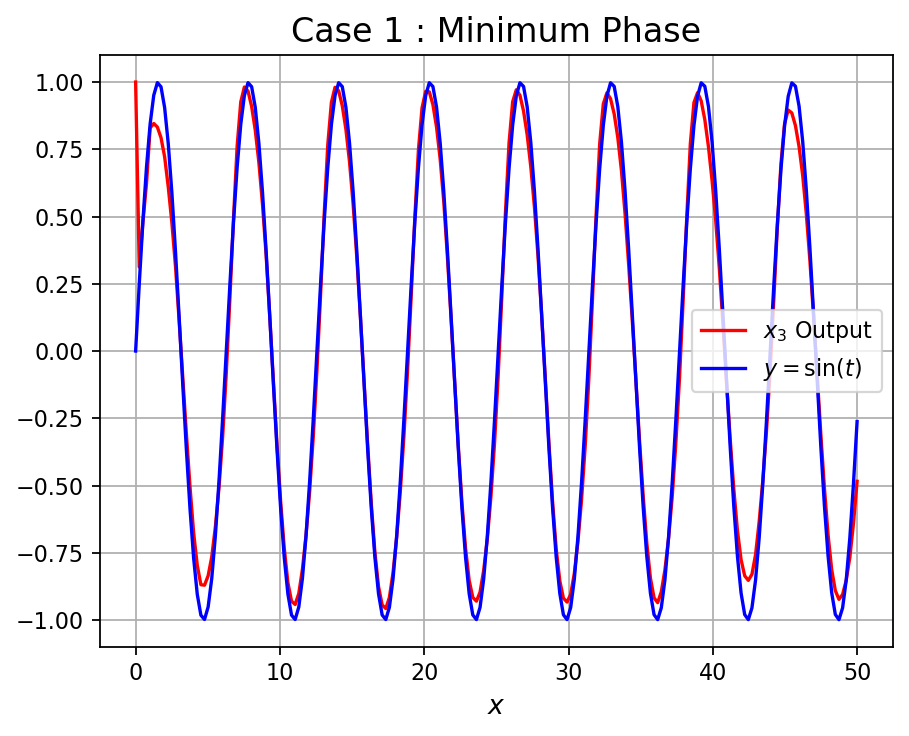

In [139]:
plt.rcParams['figure.dpi'] = 160
ts = torch.linspace(0, T, 200).reshape(-1, 1)
v_test = PINN_Tracking_Case1.forward(ts)
x3_test = v_test[:, [2]].cpu().detach().numpy()
t_arr = ts.cpu().detach().numpy()
plt.plot(t_arr, x3_test, 'red')
plt.plot(t_arr, np.sin(t_arr), 'blue')
plt.legend([r'$x_3$ Output', r'$y=\sin(t)$'])
plt.title("Case 1 : Minimum Phase", fontsize=15)
plt.xlabel(r"$x$", fontsize=12)
plt.grid('on')
plt.savefig('case1_result.jpg')
plt.show()

## 4.2 Case 2

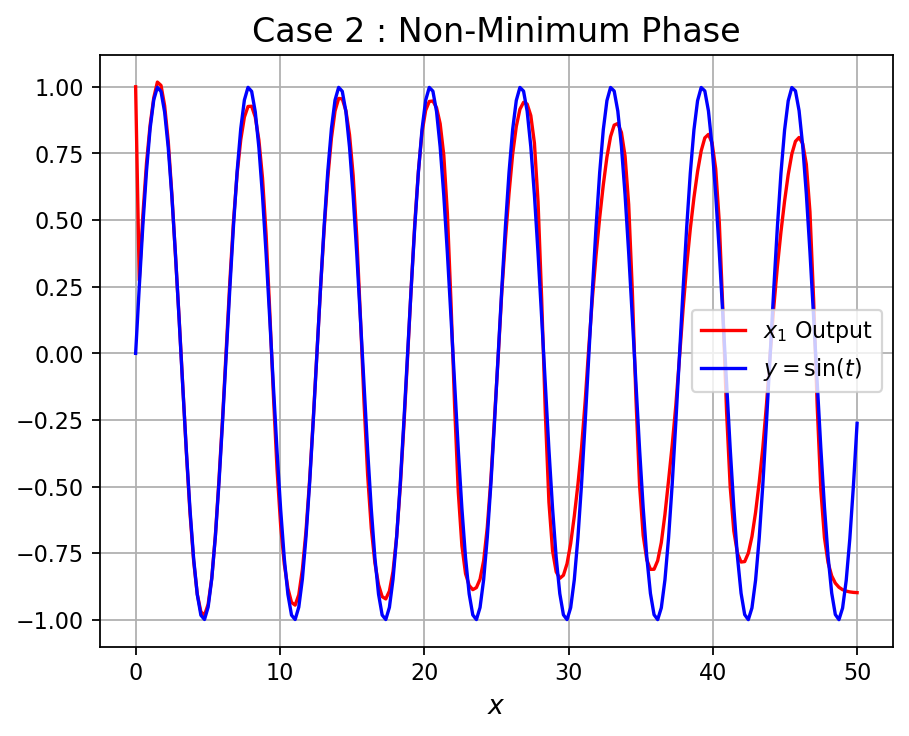

In [140]:
ts = torch.linspace(0, T, 200).reshape(-1, 1)
v_test = PINN_Tracking_Case2.forward(ts)
x1_test = v_test[:, [0]].cpu().detach().numpy()
t_arr = ts.cpu().detach().numpy()
plt.plot(t_arr, x1_test, 'red')
plt.plot(t_arr, np.sin(t_arr), 'blue')
plt.legend([r'$x_1$ Output', r'$y=\sin(t)$'])
plt.title("Case 2 : Non-Minimum Phase", fontsize=15)
plt.xlabel(r"$x$", fontsize=12)
plt.grid('on')
plt.savefig('case2_result.jpg')
plt.show()